<a href="https://colab.research.google.com/github/aeyeniay/BrainMRISegmentation/blob/main/BrainMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain MRI Segmentation**

### Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

### Connecting Google Drive to get the Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Data

In [ ]:
img_data = pd.read_csv('/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/data.csv')
img_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [ ]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
img_data.shape

(110, 18)

### Data Path Creation

*   Creating a path to MRI images and masks. The '**glob**' library gets the path to each MRI image and mask in the dataset.
*   Create data paths for directory names and masks

In [ ]:
data_path = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/data.csv'


In [ ]:
# Example
data_path[0:4]

['TCGA_CS_4941_19960909',
 '/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif',
 'TCGA_CS_4941_19960909',
 '/content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif']

In [ ]:
filenames = data_path[::2] # takes 0th, 2nd, 4th, ...
masks = data_path[1::2] # takes 1st, 3rd, 5th, ...

In [ ]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
df

,patient_id,img_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...
...,...,...
7853,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...
7854,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...
7855,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...
7856,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...


### Data Separation

*   We separated the data into original MRI images and masks. Masks have path names that contain the word "mask".

In [ ]:
original_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

In [ ]:
original_img, mask_img

(                 patient_id                                           img_path
 0     TCGA_CS_4941_19960909  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 1     TCGA_CS_4941_19960909  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 3     TCGA_CS_4941_19960909  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 5     TCGA_CS_4941_19960909  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 6     TCGA_CS_4941_19960909  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 ...                     ...                                                ...
 7850  TCGA_HT_8563_19981209  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 7852  TCGA_HT_8563_19981209  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 7854  TCGA_HT_8563_19981209  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 7855  TCGA_HT_8563_19981209  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 7857  TCGA_HT_8563_19981209  /content/drive/MyDrive/ImageProcessing/lgg-mri...
 
 [3929 rows x 2 columns],
            

### Path Sorting and Creating Dataframe

*   We sorted the MRI images and masks in a specific order. This ensures correct matching of image and mask pairs.

In [ ]:
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[114:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[114:-9]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_4.tif 
Mask path: /content/drive/MyDrive/ImageProcessing/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_4_mask.tif


*   Loading paths of original MRI images and masks into a data frame.

In [ ]:
mri_df = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_df

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
...,...,...,...
3924,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3925,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3926,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3927,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...


### Diagnosis Function

*   This is a function used to determine whether an MRI mask contains a brain tumor. It checks the highest pixel value of the mask and returns 1 (tumor present) or 0 (no tumor) accordingly.
*   cv2.imread function creates a pixel matrix of a specified image.

In [ ]:
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 :
        return 1
    else:
        return 0

In [ ]:
mri_df.head()

,patient_id,img_path,mask_path
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...


### Diagnosis Implementation

*   First one applies implementation of diagnosis
*   Second one converts all data in the 'mask_path' column to text (string) for further analysis

In [ ]:
mri_df['mask'] = mri_df['mask_path'].apply(lambda x: get_diagnosis(x))

mri_df['mask_path'] = mri_df['mask_path'].apply(lambda x: str(x))
mri_df

,patient_id,img_path,mask_path,mask
0,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
1,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
2,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
3,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
4,TCGA_CS_4941_19960909,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
...,...,...,...,...
3924,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
3925,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
3926,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
3927,TCGA_HT_8563_19981209,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0


### Column Deletion and Data Splitting

*   We removed the "patient_id" column from the data frame, which contains the patient's credentials.

In [ ]:
mri_df.drop(columns=['patient_id'],inplace=True)

*   We split the data into training, validation and test datasets.

In [ ]:
mri_train, mri_test = train_test_split(mri_df,test_size = 0.1)
mri_train, mri_val = train_test_split(mri_train,test_size = 0.2)

print('Training data shape is {0}'.format(mri_train.values.shape))
print('Test data shape is {0}'.format(mri_test.values.shape))
mri_train.sample(n=5)

Training data shape is (2828, 3)
Test data shape is (393, 3)


,img_path,mask_path,mask
3511,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,1
265,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
1009,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0
1540,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,1
624,/content/drive/MyDrive/ImageProcessing/lgg-mri...,/content/drive/MyDrive/ImageProcessing/lgg-mri...,0


### Exploratory Data Analysis (EDA)

#### Check Balancing in Data

<Axes: title={'center': 'Count of Tumour vs No Tumour'}>

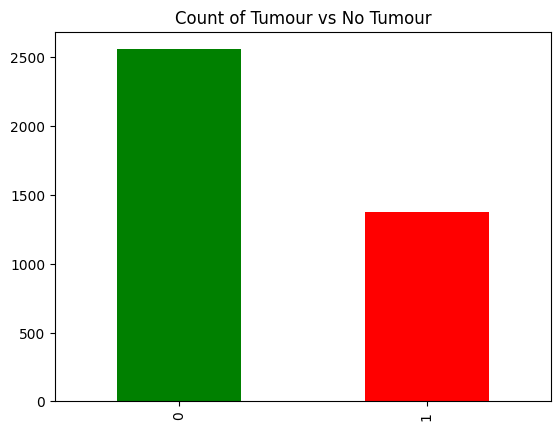

In [ ]:
mri_df['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [ ]:
mri_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

### Image Visualization

#### Visualising the Brain MRI with Tumour

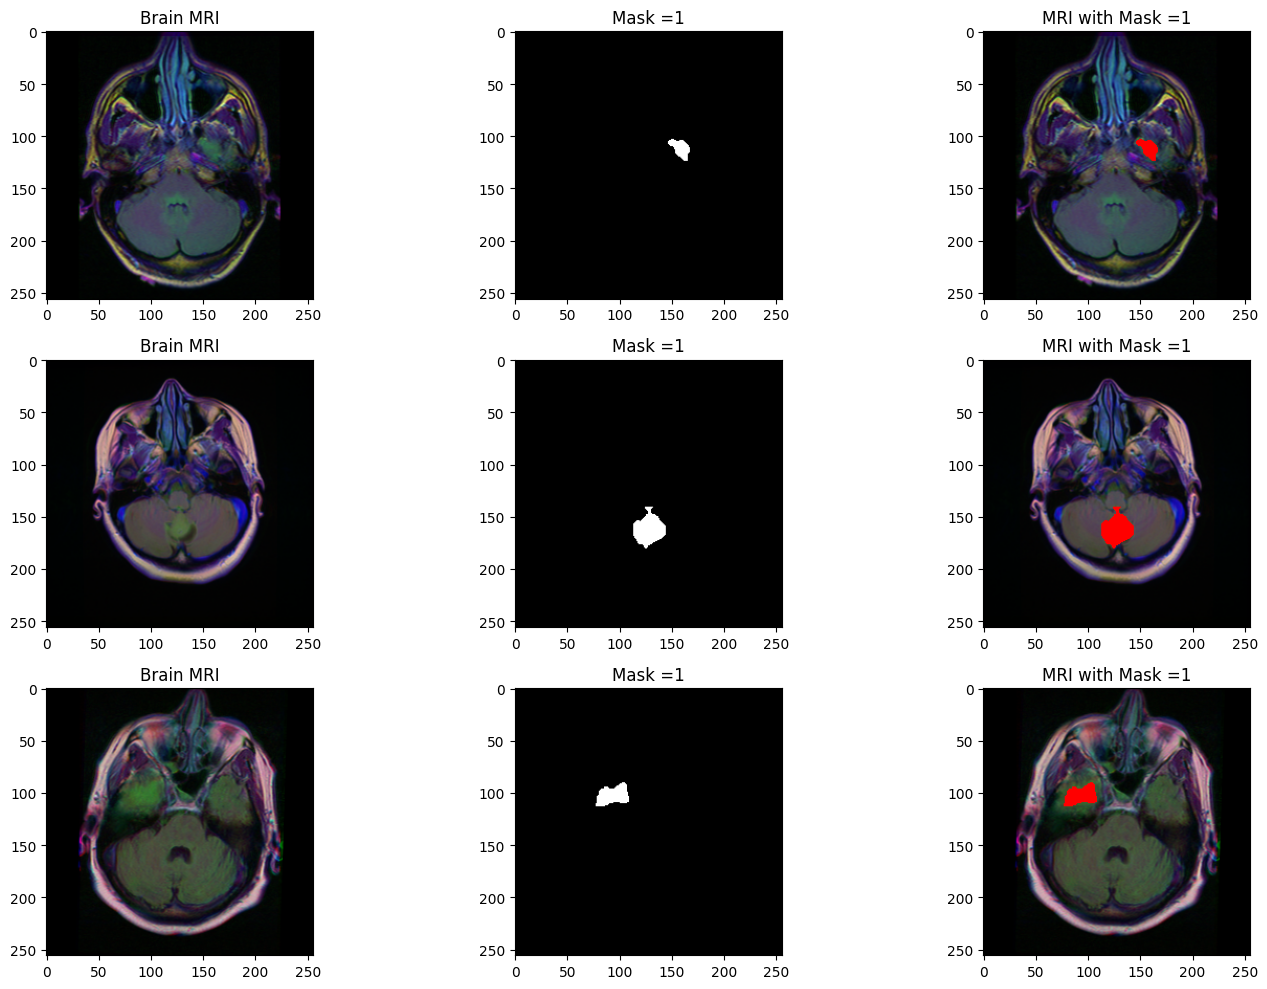

In [ ]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(15,10))
for mask in mri_df['mask']:
    if (mask==1):
        img = io.imread(mri_df.img_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_df['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_df['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break

fig.tight_layout()